In [1]:
!wget https://raw.githubusercontent.com/lablnet/covid19/main/analysis/dailyStats.csv

--2022-05-23 03:04:20--  https://raw.githubusercontent.com/lablnet/covid19/main/analysis/dailyStats.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16603 (16K) [text/plain]
Saving to: 'dailyStats.csv.2'

dailyStats.csv.2    100%[===================>]  16.21K  --.-KB/s    in 0.001s  

2022-05-23 03:04:21 (20.2 MB/s) - 'dailyStats.csv.2' saved [16603/16603]



In [210]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.tsa.deterministic import DeterministicProcess
from sklearn.linear_model import LinearRegression
import seaborn as sns
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor


In [131]:
#read /content/dailyStats.csv

df=pd.read_csv('./dailyStats.csv')
df.head()

,sr#,datetime,new_cases,
0,1,2020-03-17,25,NaN
1,2,2020-02-26,1,NaN
2,3,2020-03-15,2,NaN
3,4,2020-03-18,9,NaN
4,5,2020-03-14,1,NaN


In [132]:
#make datetime as index
df.index = pd.to_datetime(df['datetime'])
#remove datetime column
df.drop(['datetime'], axis=1, inplace=True)
df.drop(['sr# '], axis=1, inplace=True)

In [133]:
#remove column wih null values
df = df[df.columns[~df.isnull().all()]]
df

,new_cases
datetime,
2020-03-17,25
2020-02-26,1
2020-03-15,2
2020-03-18,9
2020-03-14,1
...,...
2022-05-15,77
2022-05-18,205
2022-05-19,80


In [134]:
dates = pd.date_range(df.index[0], df.index[-1])
df=df[~df.index.duplicated(keep='first')]
df = df.reindex(dates, fill_value=np.NaN)


In [139]:
df=df.fillna(method='ffill')

<AxesSubplot:>

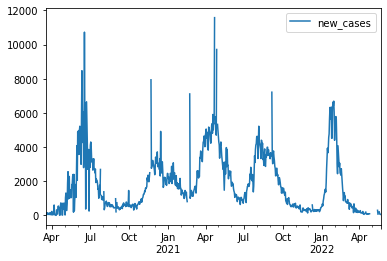

In [135]:
df.plot()

In [185]:
yearly=df.resample("Y").agg(["mean", "median", "std"])
yearly

new_cases                     
                   mean  median          std
2020-12-31  1604.172414   928.0  1603.235370
2021-12-31  2205.167123  1754.0  1747.592796
2022-12-31  1501.531915   603.0  1932.469684

<AxesSubplot:>

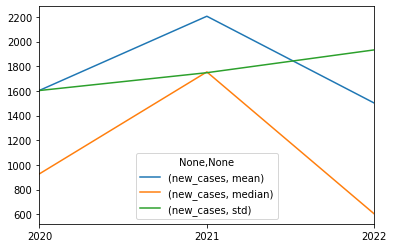

In [186]:
yearly.plot()

In [9]:
df.index.month

Int64Index([3, 2, 3, 3, 3, 3, 3, 3, 3, 3,
            ...
            4, 4, 4, 5, 5, 5, 5, 5, 5, 5],
           dtype='int64', name='datetime', length=817)

<AxesSubplot:>

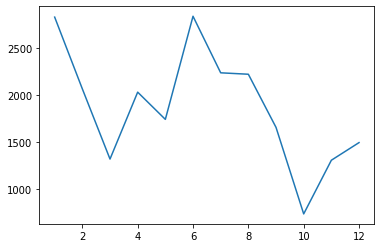

In [187]:
#monthly average cases
df.groupby(df.index.month).new_cases.mean().plot()

<AxesSubplot:title={'center':'monthly cases'}>

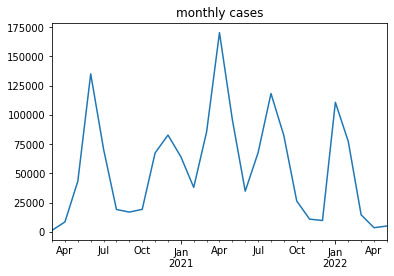

In [188]:
df.resample('M').new_cases.sum().plot(title="monthly cases")

Let's zoom April

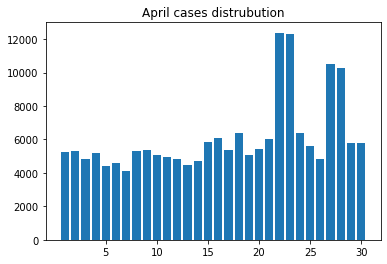

In [189]:

ax = plt.subplot()
plt.bar(range(1, 31),pd.DataFrame(df.new_cases[df.index.month==4]).groupby(lambda x: (x.day)).new_cases.sum())
ax.set_title("April cases distrubution")
ax.set_xticks(ticks=range(5, 31, 5))

Trend

In [13]:
# from statsmodels.tsa.seasonal import seasonal_decompose
# result = seasonal_decompose(df.index, model='additive')  
# result.plot();

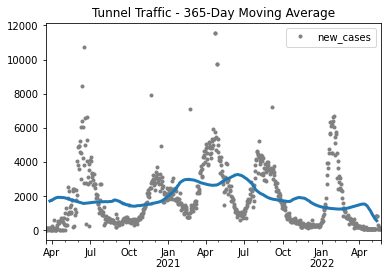

In [190]:
moving_average = df.rolling(
    window=180,       # 365-day window
    center=True,      # puts the average at the center of the window
    min_periods=100,  # choose about half the window size
).mean()  
ax = df.plot(style=".", color="0.5")
moving_average.plot(
    ax=ax, linewidth=3, title="Tunnel Traffic - 365-Day Moving Average", legend=False,
);
#plot show that trend is non linear

In [191]:

dp = DeterministicProcess(
    index=df.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=2,             # the time dummy (trend)
    drop=True,           # drop terms if necessary to avoid collinearity
)
# `in_sample` creates features for the dates given in the `index` argument
X = dp.in_sample()

X.head()

,const,trend,trend_squared
2020-03-17,1.0,1.0,1.0
2020-03-18,1.0,2.0,4.0
2020-03-19,1.0,3.0,9.0
2020-03-20,1.0,4.0,16.0
2020-03-21,1.0,5.0,25.0


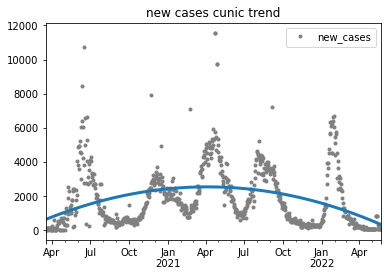

In [192]:
#fitting regression model
y =df["new_cases"]  # the target

# The intercept is the same as the `const` feature from
# DeterministicProcess. LinearRegression behaves badly with duplicated
# features, so we need to be sure to exclude it here.
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
ax = df.plot(style=".", color="0.5", title="new cases cunic trend")
_ = y_pred.plot(ax=ax, linewidth=3, label="Trend")

In [193]:
#future prediction
X = dp.out_of_sample(steps=30)

y_fore = pd.Series(model.predict(X), index=X.index)

y_fore.head()

2022-05-22    345.271226
2022-05-23    334.574040
2022-05-24    323.850944
2022-05-25    313.101938
2022-05-26    302.327021
Freq: D, dtype: float64

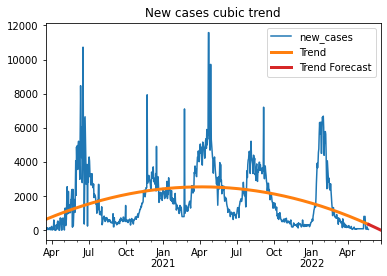

In [194]:
ax = df.plot(title="New cases cubic trend")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend")
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color="C3")
_ = ax.legend()

Seanality

In [195]:

from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

fourier = CalendarFourier(freq="A", order=10)  # 10 sin/cos pairs for "A"nnual seasonality

dp = DeterministicProcess(
    index=df.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,
   # drop terms to avoid collinearity
)

x=dp.in_sample()


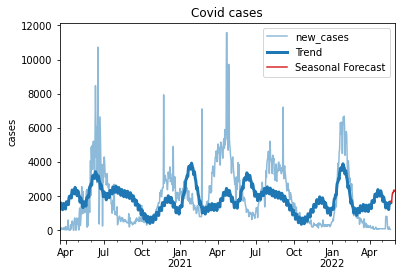

In [196]:
from sklearn.linear_model import LinearRegression
y=df['new_cases']
model = LinearRegression()
model.fit(x, y)

y_pred = pd.Series(model.predict(x), index=x.index)
X_fore = dp.out_of_sample(steps=10)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot( alpha=0.5, title="Covid cases", ylabel="cases")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='C0')
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')

ax.legend();

In [197]:
X_fore = dp.out_of_sample(steps=90)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')
ax.legend()
y_fore

2022-05-22    1702.185912
2022-05-23    1700.260583
2022-05-24    1609.953721
2022-05-25    1951.622036
2022-05-26    2165.061137
                 ...     
2022-08-15    2064.486888
2022-08-16    1881.397431
2022-08-17    2125.123239
2022-08-18    2236.542536
2022-08-19    2174.749418
Freq: D, Length: 90, dtype: float64

/tmp/ipykernel_8179/826537838.py:33: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  plot_periodogram(df.new_cases);


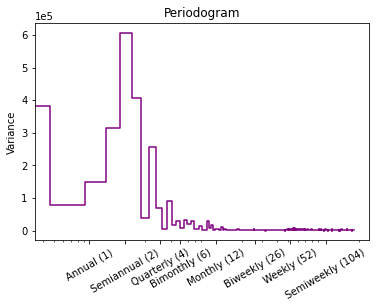

In [198]:
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax
plot_periodogram(df.new_cases);


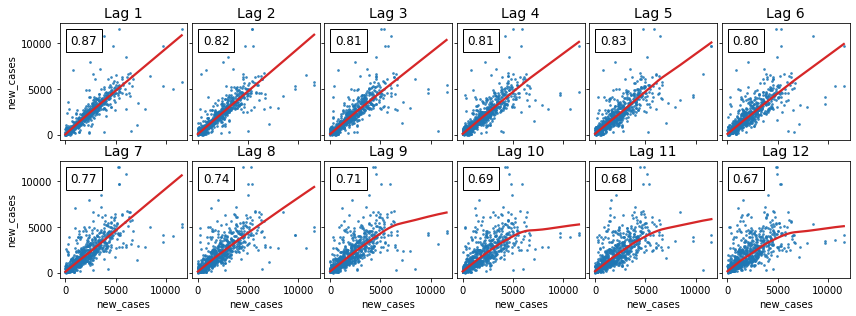

In [199]:
def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax
def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig
_ = plot_lags(df.new_cases, lags=12, nrows=2)

/home/studio-lab-user/.conda/envs/stat/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


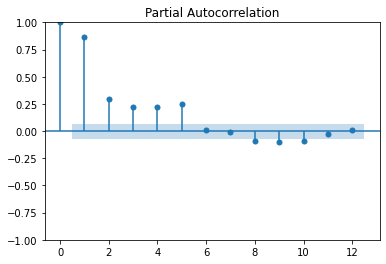

In [200]:
#plotting autocorrelation
from statsmodels.graphics.tsaplots import plot_pacf
_ = plot_pacf(df.new_cases, lags=12)

In [201]:
def make_lags(ts, lags):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(1, lags + 1)
        },
        axis=1)


X = make_lags(df.new_cases, lags=6)
X = X.fillna(0.0)
X_f=df.tail(6)
X_f=make_lags(X_f.new_cases,lags=6)
X_f = X_f.fillna(0.0)

In [202]:
y=df.new_cases.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=60, shuffle=False)
model = LinearRegression()  # `fit_intercept=True` since we didn't use DeterministicProcess
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_train), index=y_train.index)
y_fore = pd.Series(model.predict(X_test), index=y_test.index)

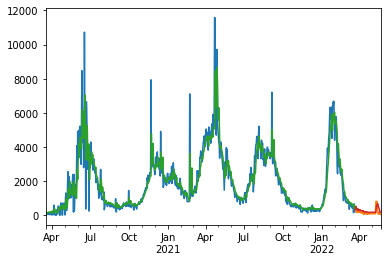

In [203]:
ax = y_train.plot()
ax = y_test.plot()
ax = y_pred.plot(ax=ax)
_ = y_fore.plot(ax=ax, color='C3')

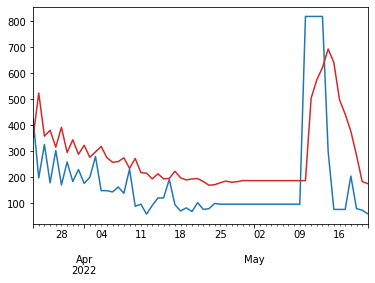

In [204]:
ax = y_test.plot()
_ = y_fore.plot(ax=ax, color='C3')

In [205]:
y_f=pd.Series(model.predict(X_f), index=X_f.index)
#we are going to use this prediction

In [ ]:
# import statsmodels.api as sm
# data=df.copy()
# data.index = pd.DatetimeIndex(data.to_timestamp()).to_period('M')
# fit = sm.tsa.arima.ARIMA(data, seasonal_order=(0, 1, 1, 7)).fit()
# fit.summary()


In [ ]:
# fit.forecast(100).plot()

Hybrid

/tmp/ipykernel_8179/1859714217.py:31: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  axs = y_test.plot(color='0.25', subplots=True, sharex=True, ax=axs)
/tmp/ipykernel_8179/1859714217.py:32: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  axs = y_fit.plot(color='C0', subplots=True, sharex=True, ax=axs)
/tmp/ipykernel_8179/1859714217.py:33: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  axs = y_pred.plot(color='C3', subplots=True, sharex=True, ax=axs)


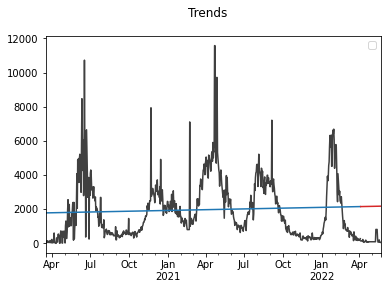

In [206]:
y=df.copy()
dp = DeterministicProcess(
    index=y.index,  # dates from the training data
    constant=True,  # the intercept
    order=1,        # quadratic trend
    drop=True,      # drop terms to avoid collinearity
)
X = dp.in_sample() 
idx_train, idx_test = train_test_split(
    y.index, test_size=12 * 4, shuffle=False,
)
X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]
model = LinearRegression(fit_intercept=False)
model.fit(X_train, y_train)

# Make predictions
y_fit = pd.DataFrame(
    model.predict(X_train),
    index=y_train.index,
    columns=y_train.columns,
)
y_pred = pd.DataFrame(
    model.predict(X_test),
    index=y_test.index,
    columns=y_test.columns,
)

# Plot
axs = y_train.plot(color='0.25', subplots=True, sharex=True)
axs = y_test.plot(color='0.25', subplots=True, sharex=True, ax=axs)
axs = y_fit.plot(color='C0', subplots=True, sharex=True, ax=axs)
axs = y_pred.plot(color='C3', subplots=True, sharex=True, ax=axs)
for ax in axs: ax.legend([])
_ = plt.suptitle("Trends")

In [207]:
X=df.copy()
X["day"] = X.index.day  # values are day of the month
X=X.drop(['new_cases'],axis=1)


In [208]:
X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]


In [211]:
y_resid=y_train-y_fit
y_resid.fillna(0)
xgb = XGBRegressor()
xgb.fit(X_train, y_resid)


# Add the predicted residuals onto the predicted trends
y_fit = y_fit.stack().squeeze()    # trend from training set
y_pred = y_pred.stack().squeeze()
y_fit_boosted = xgb.predict(X_train) + y_fit
y_pred_boosted = xgb.predict(X_test) + y_pred

<AxesSubplot:>

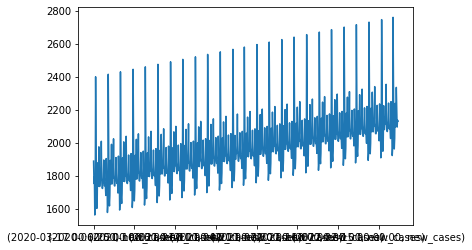

In [212]:
y_fit_boosted.plot()

In [213]:
y_pred = pd.DataFrame(
    model.predict(X_test),
    index=y_test.index,
    columns=y_test.columns,
)

/home/studio-lab-user/.conda/envs/stat/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- day
Feature names seen at fit time, yet now missing:
- const
- trend

  warnings.warn(message, FutureWarning)


ValueError: X has 1 features, but LinearRegression is expecting 2 features as input.

<AxesSubplot:xlabel='datetime,None'>

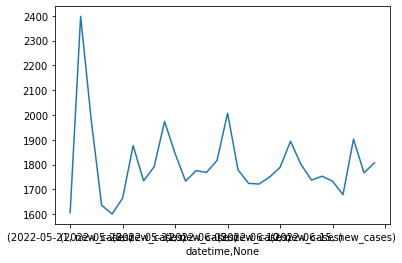

In [214]:
def make_data_for_forecast(n_days=10):
    f=pd.DataFrame(pd.period_range(start=df.tail(1).index[0],periods=n_days),columns=["datetime"])
    f.index=f['datetime']
    f=f.drop(['datetime'],axis=1)
    f['day']=f.index.day
    return f
def pred_regression(f):
    dp = DeterministicProcess(
    index=f.index,  # dates from the training data
    constant=True,  # the intercept
    order=1,        # quadratic trend
    drop=True,      # drop terms to avoid collinearity
)
    f_1 = dp.in_sample() 

    y_pred = pd.DataFrame(
    model.predict(f_1),
    index=f.index,
    columns=y.columns)
    return y_pred
def prediction(f):
    y_pred=pred_regression(f)
    y_pred = y_pred.stack().squeeze()
    y_fore_booasted = xgb.predict(f) + y_pred
    return y_fore_booasted

f=make_data_for_forecast(30)
pred=prediction(f)
pred.plot()

In [ ]:
# pred=pred.to_frame().unstack()[0]
# pred.to_csv('pred.csv')

/home/studio-lab-user/.conda/envs/stat/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


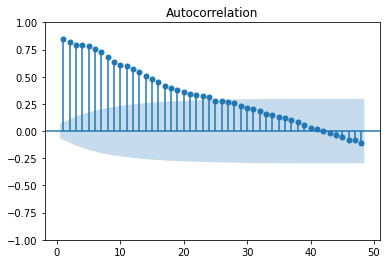

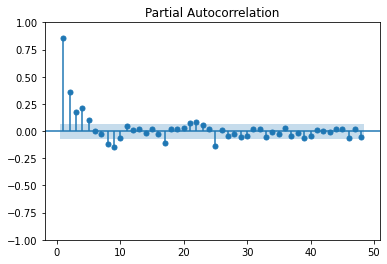

In [13]:
#plot acf and pacf of diff
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df, lags=48, zero=False);
plot_pacf(df, lags=48, zero=False);

In [151]:
cases_diff=df['new_cases'].diff(3)

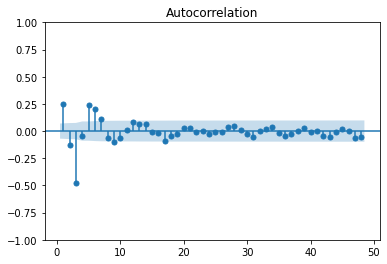

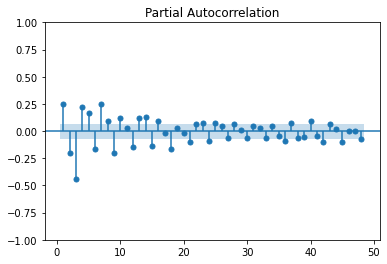

In [152]:
plot_acf(cases_diff.dropna(), lags=48, zero=False);
plot_pacf(cases_diff.dropna(), lags=48, zero=False);

In [168]:
from statsmodels.tsa.arima.model import ARIMA
model_arima =ARIMA(df, order=(6,1,1))
result = model_arima.fit(method_kwargs={"warn_convergence": False})

In [169]:
from sklearn.metrics import mean_squared_error
predictions = result.predict(start=0, end=len(df['new_cases'])-1, dynamic=False)
mean_squared_error(df['new_cases'], predictions)

593233.4552369934

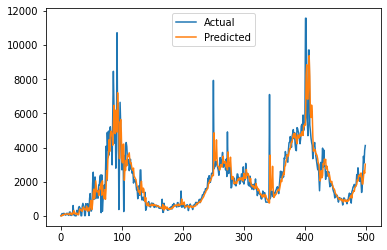

In [171]:
#plot predictions with actual values
plt.plot(df['new_cases'][:500].values, label='Actual')
plt.plot(predictions[:500].values, label='Predicted')
plt.legend()


In [172]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              new_cases   No. Observations:                  796
Model:                 ARIMA(6, 1, 1)   Log Likelihood               -6413.052
Date:                Mon, 23 May 2022   AIC                          12842.104
Time:                        04:43:44   BIC                          12879.531
Sample:                    03-17-2020   HQIC                         12856.486
                         - 05-21-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2544      0.099      2.575      0.010       0.061       0.448
ar.L2          0.0137      0.059      0.235      0.815      -0.101       0.128
ar.L3          0.0069      0.039      0.177      0.860      -0.070       0.084
ar.L4          0.0588      0.037      1.576      0.115      -0.014       0.132
ar.L5          0.2298      0.029      7.897      0.000       0.173       0.287
ar.L6          0.0726      0.025      2.928      0.003       0.024       0.121
ma.L1         -0.8113      0.100     -8.080      0.000      -1.008      -0.615
sigma2      6.054e+05   9051.599     66.889      0.000    5.88e+05    6.23e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):             18663.69
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               0.26   Skew:                             1.83
Prob(H) (two-sided):                  0.00   Kurtosis:                        26.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

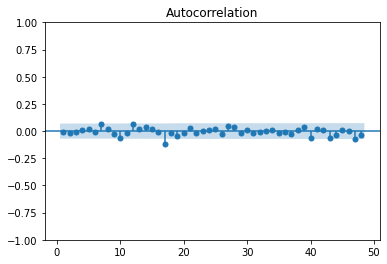

In [173]:
plot_acf(result.resid, lags=48, zero=False);


In [144]:
predictions = result.predict(start=len(df['new_cases'])-1, end=(len(df['new_cases'])-1)+100)

<AxesSubplot:>

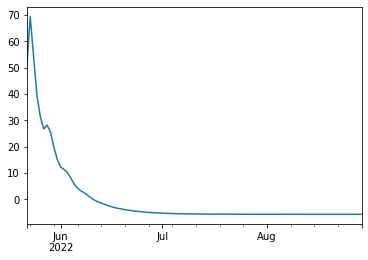

In [175]:
result.forecast(steps=100).plot()

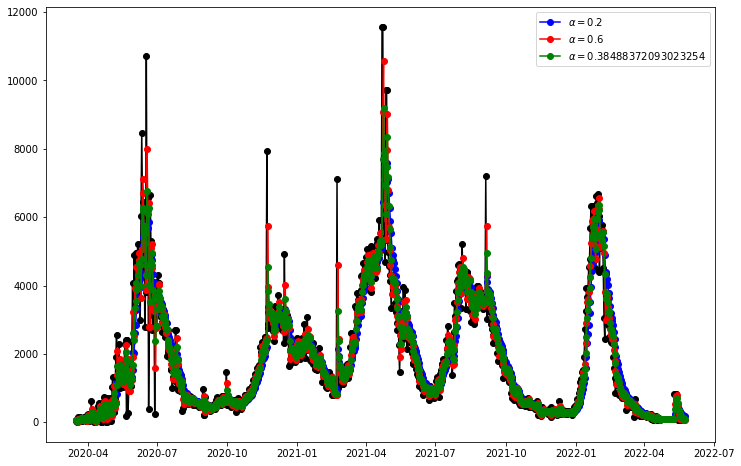

In [176]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
fit1 = SimpleExpSmoothing(df, initialization_method="heuristic").fit(
    smoothing_level=0.2, optimized=False
)
fcast1 = fit1.forecast(3).rename(r"$\alpha=0.2$")
fit2 = SimpleExpSmoothing(df, initialization_method="heuristic").fit(
    smoothing_level=0.6, optimized=False
)
fcast2 = fit2.forecast(3).rename(r"$\alpha=0.6$")
fit3 = SimpleExpSmoothing(df, initialization_method="estimated").fit()
fcast3 = fit3.forecast(3).rename(r"$\alpha=%s$" % fit3.model.params["smoothing_level"])

plt.figure(figsize=(12, 8))
plt.plot(df, marker="o", color="black")
plt.plot(fit1.fittedvalues, marker="o", color="blue")
(line1,) = plt.plot(fcast1, marker="o", color="blue")
plt.plot(fit2.fittedvalues, marker="o", color="red")
(line2,) = plt.plot(fcast2, marker="o", color="red")
plt.plot(fit3.fittedvalues, marker="o", color="green")
(line3,) = plt.plot(fcast3, marker="o", color="green")
plt.legend([line1, line2, line3], [fcast1.name, fcast2.name, fcast3.name])

/home/studio-lab-user/.conda/envs/stat/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


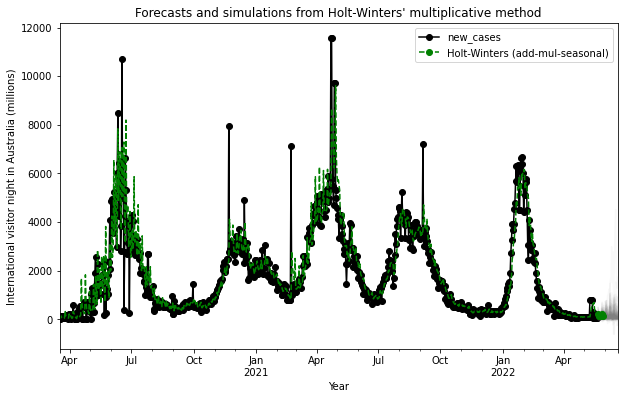

In [183]:
fit = ExponentialSmoothing(
    df,
    seasonal_periods=6,
    trend="add",
    seasonal="mul",
    initialization_method="estimated",
).fit()
simulations = fit.simulate(30, repetitions=100, error="mul")

ax = df.plot(
    figsize=(10, 6),
    marker="o",
    color="black",
    title="Forecasts and simulations from Holt-Winters' multiplicative method",
)
ax.set_ylabel("International visitor night in Australia (millions)")
ax.set_xlabel("Year")
fit.fittedvalues.plot(ax=ax, style="--", color="green")
simulations.plot(ax=ax, style="-", alpha=0.05, color="grey", legend=False)
fit.forecast(8).rename("Holt-Winters (add-mul-seasonal)").plot(
    ax=ax, style="--", marker="o", color="green", legend=True
)
plt.show()

In [184]:
fit.summary()

Dep. Variable:,new_cases,No. Observations:,796
Model:,ExponentialSmoothing,SSE,560226256.822
Optimized:,True,AIC,10737.545
Trend:,Additive,BIC,10784.341
Seasonal:,Multiplicative,AICC,10737.943
Seasonal Periods:,6,Date:,"Mon, 23 May 2022"
Box-Cox:,False,Time:,04:49:36
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.2878571,alpha,True
smoothing_trend,0.0001,beta,True
